In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from IPython.display import clear_output

In [2]:
# C:\Users\Rotem\AppData\Local\Programs\Python\Python39\python.exe -m pip install antropy
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
sr = 1000
edf_path = "C:\\Users\\Rotem\\Data\\%s_for_tag_filtered_fix_tag.edf"
full_edf_path = 'C:\\Users\\Rotem\\Data\\P%s_full_filtered.edf'

### segment Lilach tags to 1 sec intervals

In [4]:
def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

# segment Lilach tags to 1 sec intervals
def format_raw_spikes(subj, channels): 
    epochs, epochs_random = [], []
    window_size = sr
    raw = mne.io.read_raw_edf(edf_path % subj)
    spikes = raw.annotations
    spikes_df = pd.DataFrame(spikes)
    end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
    spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
    spikes_df = spikes_df.drop_duplicates(subset=['onset'])
    complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

    # from first tags round- only some spikes here and there
    random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
    raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
    for onset in random_spikes_df['onset']:
        curr_block = raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)]
        epochs_random.append(curr_block)
    y_windows_random = np.full(len(epochs_random), 1)

    # from second tags round- complete data
    raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()

    for i in range(0, raw_data.shape[1], window_size):
        curr_block = raw_data[:, i: i  + window_size]
        if i + window_size < raw_data.shape[1]:
            epochs.append(curr_block)

    y_windows = np.zeros(len(epochs))
    for onset in complete_spikes_df['onset']:
        y_windows[int(onset * 1000 / window_size)] = 1

    epochs = np.concatenate((epochs, epochs_random))
    y_windows = np.concatenate((y_windows, y_windows_random))
    # Normalize per channel
    epochs_norm = np.empty(epochs.shape)
    for i in range(epochs.shape[1]):
        chan_mean = epochs[:, i, :].mean()
        chan_std = epochs[:, i, :].std()
        epochs_norm[:, i, :] = (epochs[:, i, :] - chan_mean) / chan_std

    # np.hstack((epochs_norm, np.arange(epochs_norm.shape[0])))
    return epochs_norm, y_windows

# Segment the full night data
def format_raw_night(subj, channels):
    epochs = []
    window_size = sr
    # check if I need to create bipolar channel
    if any('-' in s for s in channels):
        chans_for_bi = [s for s in channels if '-' in s][0].split('-')
        raw_bi = mne.io.read_raw_edf(full_edf_path % subj).pick_channels(chans_for_bi).resample(sr)
        raw_bi = mne.set_bipolar_reference(raw_bi, chans_for_bi[0], chans_for_bi[1], 
                                            ch_name=f'{chans_for_bi[0]}-{chans_for_bi[1]}', drop_refs=True)
        # Get the other channels and concat
        non_bi_chans = [x for x in channels if '-' not in x]
        raw = mne.io.read_raw_edf(full_edf_path % subj).pick_channels(non_bi_chans).resample(sr)
        raw.add_channels([raw_bi], force_update_info=True)
        raw_data = raw.get_data()
    else:
        raw_data = mne.io.read_raw_edf(full_edf_path % subj).pick_channels([channel]).resample(sr).get_data()
    
    for i in range(0, raw_data.shape[1], window_size):
        curr_block = raw_data[:, i: i  + window_size]
        if i + window_size < raw_data.shape[1]:
            epochs.append(curr_block)
    
    # Normalize per channel
    epochs = np.array(epochs)
    epochs_norm = np.empty(epochs.shape)
    for i in range(epochs.shape[1]):
        chan_mean = epochs[:, i, :].mean()
        chan_std = epochs[:, i, :].std()
        epochs_norm[:, i, :] = (epochs[:, i, :] - chan_mean) / chan_std
    
    return np.array(epochs_norm)

def predict_all_y(subjects=['38', '396', '398', '402', '406', '415', '416']):
    # neighbors = {'R': ['RAH1-RAH2', 'RA1'], 'L': ['LAH1-LAH2', 'LA1']}
    side1_y = None
    y_all = np.empty(0)
    for subj in subjects:
        # for subj in ['398']:
        for channel in [['RAH1', 'RA1', 'RAH1-RAH2'],['LAH1', 'LA1', 'LAH1-LAH2']]:
            if not ((subj == '396' and channel[0] == 'RAH1') or (subj == '38' and channel[0] == 'LAH1')):
                x = format_raw_night(subj, channel)

                # Here I have all features for one side
                if side1_y is None:
                    side1_y = model.predict(x)
                    side1_y =  np.array([1 if p > 0.5 else 0 for p in side1_y.T[1]])

        if subj in ['38', '396']:
            y_all = np.concatenate((y_all, side1_y))
        else:
            side2_y = model.predict(x)
            side2_y = np.array([1 if p > 0.5 else 0 for p in side2_y.T[1]])
            y_bilateral = side1_y + side2_y
            y_bilateral[y_bilateral == 2] = 1
            y_all = np.concatenate((y_all, y_bilateral))

        side1_y = None

    return y_all

def format_combine_channel(edf, chans=['PZ' ,'C3' ,'C4']):
    epochs = []
    window_size = sr

    raw = mne.io.read_raw_edf(edf).pick_channels(chans).resample(sr)
    raw = mne.channels.combine_channels(raw, {'avg': [0, 1, 2]}, method='mean')
    raw_data = raw.get_data()

    for i in range(0, len(raw_data[0]), window_size):
        curr_block = raw_data[:, i: i  + window_size].T
        if i + window_size < len(raw_data[0]):
            epochs.append(curr_block)
    return np.array(epochs)

def get_all_feat_avg_channels(subjects=['38', '396', '398', '402', '406', '415', '416']):
    x_all = np.empty((0, sr, 1))
    for subj in subjects:
        x = format_combine_channel(full_edf_path % subj)
        x_all = np.concatenate([x_all, x], axis=0)

    return x_all

def get_all_feat_eog(eog_num, subjects=['38', '396', '398', '402', '406', '415', '416']):
    x_all = np.empty((0, 1, sr))
    window_size = sr
    for subj in subjects:
        epochs = []
        raw_data = mne.io.read_raw_edf(full_edf_path % subj).pick_channels(['EOG' + eog_num]).resample(sr).get_data()

        for i in range(0, raw_data.shape[1], window_size):
            curr_block = raw_data[:, i: i  + window_size]
            if i + window_size < raw_data.shape[1]:
                epochs.append(curr_block)
    
        epochs = np.array(epochs)
        subj_mean = epochs.mean()
        subj_std = epochs.std()
        final_epochs = (epochs - subj_mean) / subj_std 
        x_all = np.concatenate([x_all, final_epochs], axis=0)

    return x_all

# def plt_cls():
#     X_train, X_test, y_train, y_test = train_test_split(feat, y, stratify=y, random_state=20)
#     cf_matrix = confusion_matrix(y_test, [p > 0.5 for p in y_pred.T[1]])
#     metrics = get_metrics(cf_matrix)
#     disp = ConfusionMatrixDisplay(cf_matrix)
#     f, axes = plt.subplots(1, 1, figsize=(10, 5), sharey='row')
#     disp.plot(ax=axes, xticks_rotation=45)
#     text = """precision: {0}
#             recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
#     axes.annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
#             xytext=(-60, -40), textcoords='offset points',
#             ha='right', va='top')
#     disp.im_.colorbar.remove()
#     disp.ax_.set_xlabel('')

# f.text(0.45, 0.1, 'Predicted label', ha='left')

In [5]:
y_all = np.empty(0)
x_all = None
for subj in ['38', '396', '398', '402', '406', '415', '416']:
    for channel in [['RAH1', 'RA1', 'RAH1-RAH2'],['LAH1', 'LA1', 'LAH1-LAH2']]:
    # for channel in [['RAH1'],['LAH1']]:
        if not ((subj == '396' and channel[0] == 'RAH1') or (subj == '38' and channel[0] == 'LAH1')):
            x, y = format_raw_spikes(subj, channel)
            y_all = np.concatenate((y_all, y))
            if x_all is None:
                x_all = x
            else:
                x_all = np.concatenate((x_all, x))
               
clear_output()

In [6]:
# adding a col od epoch id
x_with_id = []
for i, mat in enumerate(x_all):
    curr_df = pd.DataFrame(mat)
    curr_df.insert(loc=0, column='epoch_id', value=i)
    x_with_id.append(curr_df)

x_with_id_np = np.array(x_with_id)

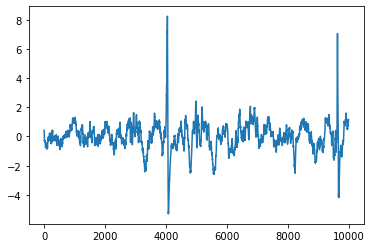

In [7]:
plt.plot(np.concatenate(x_with_id_np[:10, 1, 1:]))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_with_id_np, y_all, stratify=y_all, random_state=30)
x_train_data = x_train[:, :, 1:]
x_train_data_4 = np.expand_dims(x_train_data, axis=3)
x_test_data = x_test[:, :, 1:]

In [ ]:
x_train_data.shape

In [ ]:
x_train_data_4.shape

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
# idx = np.random.permutation(len(x_train))
# x_train = x_train[idx]
# y_train = y_train[idx]

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3,50), padding="same", strides=(1, 10), input_shape=input_shape[1:])(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.MaxPooling2D(pool_size=(3, 20), padding="same", strides=(1, 1))(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv2D(filters=64, kernel_size=(3,50), padding="same", strides=(1, 10), input_shape=input_shape[1:])(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.MaxPooling2D(pool_size=(3, 20), padding="same", strides=(1, 1))(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv2D(filters=64, kernel_size=(3,50), padding="same", strides=(1, 10), input_shape=input_shape[1:])(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.MaxPooling2D(pool_size=(3, 20), padding="same", strides=(1, 1))(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling2D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

def make_scalp_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv2D(filters=64, kernel_size=(1,50), padding="same", strides=(1, 10), input_shape=input_shape[1:])(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.MaxPooling2D(pool_size=(1, 20), padding="same", strides=(1, 1))(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv2D(filters=64, kernel_size=(1,50), padding="same", strides=(1, 10), input_shape=input_shape[1:])(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.MaxPooling2D(pool_size=(1, 20), padding="same", strides=(1, 1))(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv2D(filters=64, kernel_size=(1,50), padding="same", strides=(1, 10), input_shape=input_shape[1:])(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.MaxPooling2D(pool_size=(1, 20), padding="same", strides=(1, 1))(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling2D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=x_train_data_4.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train_data_4,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test_data, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test_data)

In [ ]:
# cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in y_pred[1]])
cf_matrix = confusion_matrix(y_test, [p > 0.5 for p in y_pred.T[1]])
metrics = get_metrics(cf_matrix)
disp = ConfusionMatrixDisplay(cf_matrix)
f, axes = plt.subplots(1, 1, figsize=(10, 5), sharey='row')
disp.plot(ax=axes, xticks_rotation=45)
text = """precision: {0}
          recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
axes.annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
            xytext=(-60, -40), textcoords='offset points',
            ha='right', va='top')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')

In [ ]:
# # all test predictions
# x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1])
# i_pred = np.where(y_pred.T[1]>0.5)
# for i in i_pred[0]:
#     plt.figure()
#     plt.title(i)    
#     pred_view = np.concatenate(x_test_reshape[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(4000, 5000), x_test_reshape[i], c='red')

In [ ]:
# True positives
i_pred = np.where(y_pred.T[1]>0.5)
true_pos = [i for i in y_test.nonzero()[0] if i in i_pred[0]]
for i in true_pos[:15]:
    epoch_id = int(x_test[i][0][0])
    plt.figure()
    plt.title(epoch_id)    
    pred_view = np.concatenate(x_all[epoch_id - 4: epoch_id + 5, 0, :])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_all[epoch_id, 0, :], c='red')

In [ ]:
# False positive
false_pos = [i for i in i_pred[0] if i not in y_test.nonzero()[0]]
for i in false_pos:
    epoch_id = int(x_test[i][0][0])
    plt.figure()
    plt.title(epoch_id)    
    pred_view = np.concatenate(x_all[epoch_id - 4: epoch_id + 5, 0, :])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_all[epoch_id, 0, :], c='red')

In [ ]:
# False negative (miss)
missed = [i for i in y_test.nonzero()[0] if i not in i_pred[0]]
for i in missed:
    epoch_id = int(x_test[i][0][0])
    plt.figure()
    plt.title(epoch_id)    
    pred_view = np.concatenate(x_all[epoch_id - 4: epoch_id + 5, 0, :])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_all[epoch_id, 0, :], c='red')

In [ ]:
# Train data
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1])
for i in y_train.nonzero()[0][20:30]:
    plt.figure()
    plt.title(i)
    pred_view = np.concatenate(x_train_reshape[i - 4: i + 5])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_train_reshape[i], c='red')

In [ ]:
x_train_reshape.shape

In [ ]:
y_train.nonzero()[0]

### Scalp!

In [ ]:
# run all subj (~15min, 7 subj)
y_all_bi = predict_all_y()
clear_output()
# avg_channel = get_all_feat_avg_channels()
# all_eog2 = get_all_feat_eog('2')
# clear_output()

# cls_all, pred_details = plt_cls(feat_pz, y_all_bi, stratify=True)

In [ ]:
avg_channel = get_all_feat_avg_channels()
clear_output()

In [ ]:
all_eog2 = get_all_feat_eog('2')
clear_output()

In [ ]:
# adding a col of epoch id
eog_with_id = []
for i, mat in enumerate(all_eog2):
    curr_df = pd.DataFrame(mat)
    curr_df.insert(loc=0, column='epoch_id', value=i)
    eog_with_id.append(curr_df)

eog_with_id_np = np.array(eog_with_id)

In [ ]:
x_train_scalp, x_test_scalp, y_train_scalp, y_test_scalp = train_test_split(eog_with_id_np, y_all_bi, stratify=y_all_bi, random_state=30)
x_train_scalp_data = x_train_scalp[:, :, 1:]
x_train_scalp_data_4 = np.expand_dims(x_train_scalp_data, axis=3)
x_test_scalp_data = x_test_scalp[:, :, 1:]
# x_train_scalp, x_test_scalp, y_train_scalp, y_test_scalp = train_test_split(avg_channel, y_all_bi, stratify=y_all_bi, random_state=30)

In [ ]:
x_train_scalp_data_4.shape

In [ ]:
plt.plot(np.concatenate(all_eog2[:10, 0, :]))

In [ ]:
scalp_model = make_scalp_model(input_shape=x_train_scalp_data_4.shape[1:])
keras.utils.plot_model(scalp_model, show_shapes=True)

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_scalp.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
scalp_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = scalp_model.fit(
    x_train_scalp_data_4,
    y_train_scalp,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)